# Libs

In [16]:
from __future__ import division

import torch
import torchvision
from torchvision import models
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import PIL
import PIL.Image as Image
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128

# PyTorch

In [3]:
model = models.vgg19(pretrained=True)
model

/Users/dr.rub/opt/anaconda3/envs/gig/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/dr.rub/opt/anaconda3/envs/gig/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [26]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [27]:
def load_image(image, transform=None, max_size=None, shape=None):
    try:
        image = Image.fromarray(np.uint8(image)).convert('RGB')
    except:
        image = Image.open(image)
    if max_size:
        scale_x = max_size/image.size[0]
        scale_y = max_size/image.size[1]
        size = np.array(image.size)*np.array([scale_x, scale_y])
        image = image.resize(size.astype(int), Image.LANCZOS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image

In [28]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                     std=(0.229, 0.224, 0.225))])

content = cv2.imread('./input_img/dancing.jpg')
content = load_image(content, transform, imsize)
style = load_image('./input_img/saryan.jpg', transform, shape=[content.size(3), content.size(2)])
target = torch.randn(content.data.size()).requires_grad_()

In [139]:
def get_input_optimizer(x, r):
    optimizer = torch.optim.SGD([x], lr=r)
    return optimizer

In [ ]:
leanring_rate = 0.002
optimizer = torch.optim.Adam([target], lr=leanring_rate, betas=[0.5, 0.999])

optimizer.zero_grad()
vgg_c = VGGNet().to(device).eval()
vgg_s = VGGNet().to(device).eval()
vgg_t = VGGNet().to(device)

style_weight = 0.5
sample_step, log_step = 500, 200

epoches = 20000

for epoch in range(epoches):
    content_features = vgg_c(content)
    style_features = vgg_s(style)
    target_features = vgg_t(target)
    
    style_loss = 0
    content_loss = 0
    
    for f1,f2,f3 in zip(target_features, content_features, style_features):
        
        content_loss += torch.mean((f1-f2)**2) # why lost is not Crossentropy?????

        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)
        f3 = f3.view(c, h * w)
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1 - f3)**2) / (c * h * w)

    loss = content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % log_step == 0:
        print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
               .format(epoch+1,epoches+1, content_loss.item(), style_loss.item()))
    
    if epoch % sample_step == 0:
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        img = target.clone().squeeze()
        img = denorm(img).clamp_(0, 1)
        torchvision.utils.save_image(img, f'./input_img/res/output-{epoch+1}.png')

# TensorFlow

In [2]:
def get_img(path):
    img = PIL.Image.open(path)
    img = img.resize((32, 32))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return tf.convert_to_tensor(img_array)

In [3]:
content_img = get_img('input_img/dancing.jpg')
content_img = tf.reshape(content_img, [1,32,32,3])
style_img = get_img('input_img/saryan.jpg')
style_img = tf.reshape(style_img, [1,32,32,3])
target_img = 0.5*(content_img+style_img)

2023-04-18 13:30:16.910012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False
)

vgg_layers = []
vgg_layers.append(base_model.layers[0])
for layer in base_model.layers:
    if "conv" in layer.name:
        layer.trainable = False
        vgg_layers.append(layer)

vgg_layers

In [5]:
def VGG_Net(layers):
    
    model = keras.models.Sequential()
    for layer in layers[:6]:
        layer.trainable = True
        model.add(layer)
    
    return model

In [6]:
model = VGG_Net(vgg_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block2_conv1 (Conv2D)       multiple                  73856     
                                                                 
 block2_conv2 (Conv2D)       multiple                  147584    
                                                                 
 block3_conv1 (Conv2D)       multiple                  295168    
                                                                 
Total params: 555,328
Trainable params: 555,328
Non-trainable params: 0
_________________________________________________________________


In [7]:
vgg_c = VGG_Net(vgg_layers)
vgg_s = VGG_Net(vgg_layers)
vgg_t = VGG_Net(vgg_layers)

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
b_loss = keras.losses.BinaryCrossentropy()

In [9]:
vgg_t.compile(loss=b_loss, optimizer=optimizer)

In [21]:
epochs = 100

target0 = vgg_t(target_img)

loss_collection= []
for epoch in range(epochs):

    target = vgg_t(target_img)

    loss, loss_c, loss_s = 0, 0, 0

    cont_l = content_img
    style_l = style_img
    target_l = target_img

    with tf.GradientTape() as g_tape:
        for n,layer in enumerate(vgg_t.layers):

            cont_l = vgg_c.layers[n](cont_l)
            target_l = vgg_t.layers[n](target_l)

            loss_c += tf.norm(cont_l-target_l)
            
            style_l = vgg_s.layers[n](style_l)
            _, c, h, w = style_l.shape
            style_l_t = style_l.reshape(c, h * w)
            target_l_t = target_l.reshape(c, h * w)
            
            loss_s += tf.norm(style_l_t-target_l_t)

    loss = loss_c
    grad = g_tape.gradient(loss, vgg_t.trainable_variables)
    optimizer.apply_gradients(zip(grad, vgg_t.trainable_variables))
    loss_collection.append(loss)

target1 = vgg_t(target_img)
print(tf.norm(target1-target0))

tf.Tensor(2433.4802, shape=(), dtype=float32)


Text(0, 0.5, 'Loss')

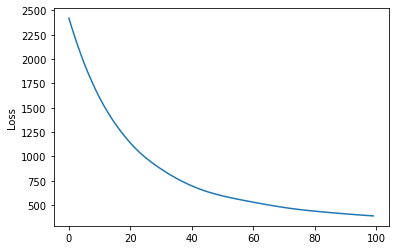

In [22]:
plt.plot(loss_collection)
plt.ylabel("Loss")